In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
import platform
from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

%matplotlib inline

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


data_batch_1
data_batch_2
data_batch_3
data_batch_4
data_batch_5
test_batch



In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

In [6]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = '../input'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [7]:
# define net
class CifarNet():
    def __init__(self):
        # conv layer
        # H2 = (H1 - F + 2P)/S +1
        # (32-5)/1 + 1 = 28
        # 28x28x32 = 25088
        # To ReLu (?x16x16x32) -> MaxPool (?x16x16x32) -> affine (8192)
        self.Wconv1 = tf.get_variable("Wconv1", shape=[5, 5, 3, 32])
        self.bconv1 = tf.get_variable("bconv1", shape=[32])
        # (32-5)/1 + 1 = 28
        # 28x28x64 = 50176
        self.Wconv2 = tf.get_variable("Wconv2", shape=[5, 5, 32, 64])
        self.bconv2 = tf.get_variable("bconv2", shape=[64])
        # affine layer with 1024
        self.W1 = tf.get_variable("W1", shape=[3136, 1024])
        self.b1 = tf.get_variable("b1", shape=[1024])
        # affine layer with 10
        self.W2 = tf.get_variable("W2", shape=[1024, 10])
        self.b2 = tf.get_variable("b2", shape=[10])        
        
    def forward(self, X, y, is_training):
        # conv2d
        # ReLu
        # conv2d
        # ReLu
        # maxpool
        # Batch Norm
        # Affine
        # Batch Norm
        # ReLu
        # Affine
        # dropout
        # Batch Norm

        # conv layer
        # H2 = (H1 - F + 2P)/S +1
        # (32-5)/1 + 1 = 28
        # 28x28x32 = 25088
        # To ReLu (?x16x16x32) -> MaxPool (?x16x16x32) -> affine (8192)

        # define our graph (e.g. two_layer_convnet) with stride 1
        conv1 = tf.nn.conv2d(X, self.Wconv1, strides=[1, 1, 1, 1], padding='SAME') + self.bconv1
        print(conv1.shape)
        # ReLU Activation Layer
        relu1 = tf.nn.relu(conv1)
        print(relu1)
        # Conv
        conv2 = tf.nn.conv2d(relu1, self.Wconv2, strides=[1, 2, 2, 1], padding='VALID') + self.bconv2
        print(conv2.shape)
        # ReLU Activation Layer
        relu2 = tf.nn.relu(conv2)
        print(relu2)
        # 2x2 Max Pooling layer with a stride of 2
        maxpool = tf.layers.max_pooling2d(relu2, pool_size=(2,2), strides=2)
        print(maxpool.shape)
        maxpool_flat = tf.reshape(maxpool,[-1,3136])
        # Spatial Batch Normalization Layer (trainable parameters, with scale and centering)
        bn1 = tf.layers.batch_normalization(inputs=maxpool_flat, center=True, scale=True, training=is_training)
        # Affine layer with 1024 output units
        affine1 = tf.matmul(bn1, self.W1) + self.b1
        print(affine1.shape)
        # vanilla batch normalization
        affine1_flat = tf.reshape(affine1,[-1,1024])
        bn2 = tf.layers.batch_normalization(inputs=affine1, center=True, scale=True, training=is_training)
        print(bn2.shape)
        # ReLU Activation Layer
        relu2 = tf.nn.relu(bn2)
        print(relu2.shape)
        # dropout
        drop1 = tf.layers.dropout(inputs=relu2, training=is_training)
        # Affine layer from 1024 input units to 10 outputs
        affine2 = tf.matmul(drop1, self.W2) + self.b2
        # vanilla batch normalization
        affine2_flat = tf.reshape(affine2,[-1,3136])
        self.predict = tf.layers.batch_normalization(inputs=affine2, center=True, scale=True, training=is_training)
        print(self.predict.shape)
        return self.predict
    
    def run(self, session, loss_val, Xd, yd,
                  epochs=1, batch_size=64, print_every=100,
                  training=None, plot_losses=False, isSoftMax=False):
        # have tensorflow compute accuracy
        if isSoftMax:
            correct_prediction = tf.nn.softmax(self.predict)
        else:
            correct_prediction = tf.equal(tf.argmax(self.predict,1), y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        # shuffle indicies
        train_indicies = np.arange(Xd.shape[0])
        np.random.shuffle(train_indicies)

        training_now = training is not None

        # setting up variables we want to compute (and optimizing)
        # if we have a training function, add that to things we compute
        variables = [mean_loss, correct_prediction, accuracy]
        if training_now:
            variables[-1] = training

        # counter 
        iter_cnt = 0
        for e in range(epochs):
            # keep track of losses and accuracy
            correct = 0
            losses = []
            # make sure we iterate over the dataset once
            for i in range(int(math.ceil(Xd.shape[0]/batch_size))):
                # generate indicies for the batch
                start_idx = (i*batch_size)%Xd.shape[0]
                idx = train_indicies[start_idx:start_idx+batch_size]

                # create a feed dictionary for this batch
                feed_dict = {X: Xd[idx,:],
                             y: yd[idx],
                             is_training: training_now }
                # get batch size
                actual_batch_size = yd[idx].shape[0]

                # have tensorflow compute loss and correct predictions
                # and (if given) perform a training step
                loss, corr, _ = session.run(variables,feed_dict=feed_dict)

                # aggregate performance stats
                losses.append(loss*actual_batch_size)
                correct += np.sum(corr)

                # print every now and then
                if training_now and (iter_cnt % print_every) == 0:
                    print("Iteration {0}: with minibatch training loss = {1:.3g} and accuracy of {2:.2g}"\
                          .format(iter_cnt,loss,np.sum(corr)/actual_batch_size))
                iter_cnt += 1
            total_correct = correct/Xd.shape[0]
            total_loss = np.sum(losses)/Xd.shape[0]
            print("Epoch {2}, Overall loss = {0:.3g} and accuracy of {1:.3g}"\
                  .format(total_loss,total_correct,e+1))
            if plot_losses:
                plt.plot(losses)
                plt.grid(True)
                plt.title('Epoch {} Loss'.format(e+1))
                plt.xlabel('minibatch number')
                plt.ylabel('minibatch loss')
                plt.show()
        return total_loss, total_correct

In [8]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.int64, [None])
is_training = tf.placeholder(tf.bool)

net = CifarNet()
net.forward(X,y,is_training)

(?, 32, 32, 32)
Tensor("Relu:0", shape=(?, 32, 32, 32), dtype=float32)
(?, 14, 14, 64)
Tensor("Relu_1:0", shape=(?, 14, 14, 64), dtype=float32)
(?, 7, 7, 64)
(?, 1024)
(?, 1024)
(?, 1024)
(?, 10)


<tf.Tensor 'batch_normalization_3/batchnorm/add_1:0' shape=(?, 10) dtype=float32>

In [9]:
# Annealing the learning rate
global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 1e-3
end_learning_rate = 5e-3
decay_steps = 10000

learning_rate = tf.train.polynomial_decay(starter_learning_rate, global_step,
                                          decay_steps, end_learning_rate,
                                          power=0.5)

exp_learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               100000, 0.96, staircase=True)


# Feel free to play with this cell
mean_loss = None
optimizer = None

# define our loss
cross_entr_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(y,10), logits=net.predict)
mean_loss = tf.reduce_mean(cross_entr_loss)

# define our optimizer
optimizer = tf.train.AdamOptimizer(exp_learning_rate)


# batch normalization in tensorflow requires this extra dependency
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(extra_update_ops):
    train_step = optimizer.minimize(mean_loss, global_step=global_step)

Training
Iteration 0: with minibatch training loss = 2.62 and accuracy of 0.12
Iteration 200: with minibatch training loss = 1.37 and accuracy of 0.53
Iteration 400: with minibatch training loss = 1.09 and accuracy of 0.66
Iteration 600: with minibatch training loss = 1.13 and accuracy of 0.66
Epoch 1, Overall loss = 1.33 and accuracy of 0.555


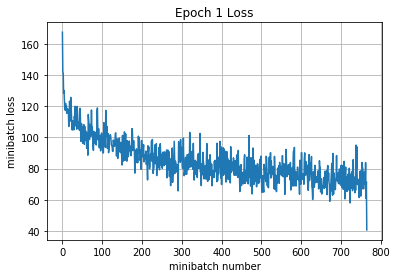

Iteration 800: with minibatch training loss = 1.15 and accuracy of 0.61
Iteration 1000: with minibatch training loss = 0.963 and accuracy of 0.7
Iteration 1200: with minibatch training loss = 1.08 and accuracy of 0.62
Iteration 1400: with minibatch training loss = 0.883 and accuracy of 0.67
Epoch 2, Overall loss = 1.01 and accuracy of 0.667


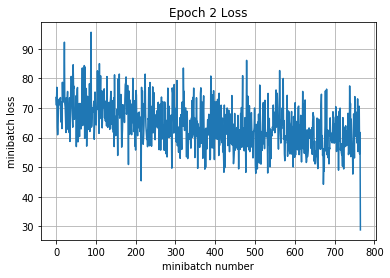

Iteration 1600: with minibatch training loss = 0.844 and accuracy of 0.69
Iteration 1800: with minibatch training loss = 0.877 and accuracy of 0.66
Iteration 2000: with minibatch training loss = 0.904 and accuracy of 0.75
Iteration 2200: with minibatch training loss = 0.791 and accuracy of 0.75
Epoch 3, Overall loss = 0.844 and accuracy of 0.721


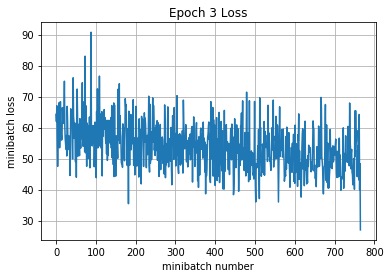

Iteration 2400: with minibatch training loss = 0.902 and accuracy of 0.61
Iteration 2600: with minibatch training loss = 0.652 and accuracy of 0.81
Iteration 2800: with minibatch training loss = 0.537 and accuracy of 0.83
Iteration 3000: with minibatch training loss = 0.677 and accuracy of 0.78
Epoch 4, Overall loss = 0.729 and accuracy of 0.761


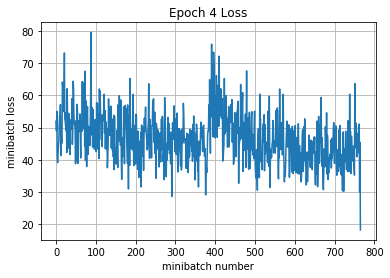

Iteration 3200: with minibatch training loss = 0.727 and accuracy of 0.75
Iteration 3400: with minibatch training loss = 0.527 and accuracy of 0.88
Iteration 3600: with minibatch training loss = 0.665 and accuracy of 0.75
Iteration 3800: with minibatch training loss = 0.582 and accuracy of 0.8
Epoch 5, Overall loss = 0.591 and accuracy of 0.813


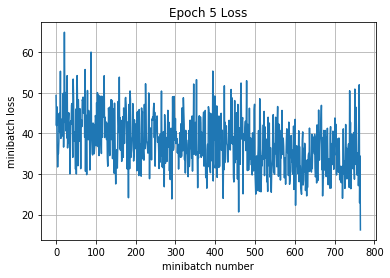

Iteration 4000: with minibatch training loss = 0.634 and accuracy of 0.77
Iteration 4200: with minibatch training loss = 0.574 and accuracy of 0.84
Iteration 4400: with minibatch training loss = 0.438 and accuracy of 0.83
Epoch 6, Overall loss = 0.479 and accuracy of 0.854


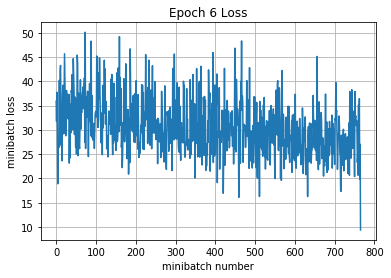

Iteration 4600: with minibatch training loss = 0.352 and accuracy of 0.88
Iteration 4800: with minibatch training loss = 0.525 and accuracy of 0.84
Iteration 5000: with minibatch training loss = 0.457 and accuracy of 0.88
Iteration 5200: with minibatch training loss = 0.468 and accuracy of 0.83
Epoch 7, Overall loss = 0.398 and accuracy of 0.879


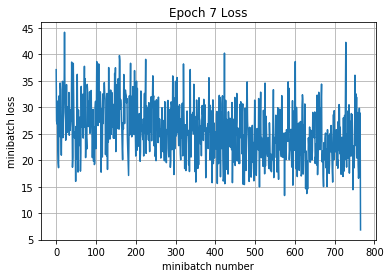

Iteration 5400: with minibatch training loss = 0.371 and accuracy of 0.91
Iteration 5600: with minibatch training loss = 0.305 and accuracy of 0.95
Iteration 5800: with minibatch training loss = 0.347 and accuracy of 0.88
Iteration 6000: with minibatch training loss = 0.368 and accuracy of 0.86
Epoch 8, Overall loss = 0.316 and accuracy of 0.908


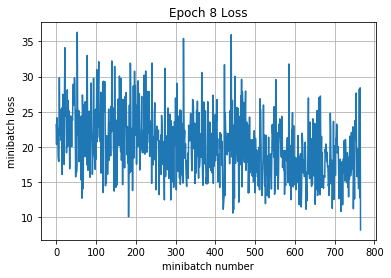

Iteration 6200: with minibatch training loss = 0.307 and accuracy of 0.89
Iteration 6400: with minibatch training loss = 0.26 and accuracy of 0.92
Iteration 6600: with minibatch training loss = 0.256 and accuracy of 0.91
Iteration 6800: with minibatch training loss = 0.235 and accuracy of 0.92
Epoch 9, Overall loss = 0.252 and accuracy of 0.929


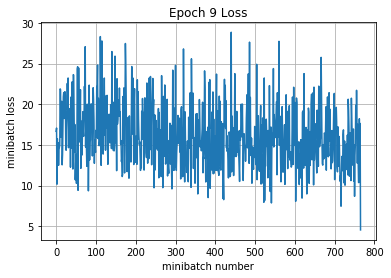

Iteration 7000: with minibatch training loss = 0.22 and accuracy of 0.95
Iteration 7200: with minibatch training loss = 0.287 and accuracy of 0.95
Iteration 7400: with minibatch training loss = 0.254 and accuracy of 0.94
Iteration 7600: with minibatch training loss = 0.222 and accuracy of 0.94
Epoch 10, Overall loss = 0.227 and accuracy of 0.936


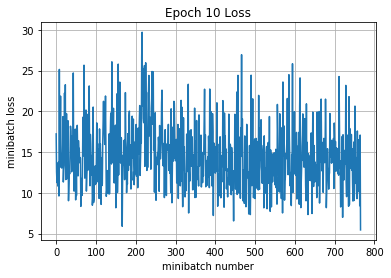

Validation
Epoch 1, Overall loss = 0.939 and accuracy of 0.708


In [10]:
# train with 10 epochs
sess = tf.Session()

try:
    with tf.device("/cpu:0") as dev:
        sess.run(tf.global_variables_initializer())
        print('Training')
        net.run(sess, mean_loss, X_train, y_train, 10, 64, 200, train_step, True)
        print('Validation')
        net.run(sess, mean_loss, X_val, y_val, 1, 64)
except tf.errors.InvalidArgumentError:
    print("no gpu found, please use Google Cloud if you want GPU acceleration") 

In [11]:
# view net model result on train  and validation set
print('Training')
net.run(sess, mean_loss, X_train, y_train, 1, 64)
print('Validation')
net.run(sess, mean_loss, X_val, y_val, 1, 64)

Training
Epoch 1, Overall loss = 0.194 and accuracy of 0.947
Validation
Epoch 1, Overall loss = 0.939 and accuracy of 0.708


(0.93886571884155279, 0.70799999999999996)

In [12]:
# check result on test
print('Test')
net.run(sess, mean_loss, X_test, y_test, 1, 64)

Test
Epoch 1, Overall loss = 0.967 and accuracy of 0.702


(0.96682215976715091, 0.70240000000000002)

In [13]:
# create a feed dictionary for this batch
feed_dict = {X: X_test,
             y: y_test,
             is_training: False}

# predict
predict = sess.run(tf.nn.softmax(net.predict), feed_dict=feed_dict)
predict_df = pd.DataFrame(predict, columns=classes)

In [14]:
predict_df.head()

,plane,car,bird,cat,deer,dog,frog,horse,ship,truck
0,0.044446,0.002206,0.002917,0.632995,0.013724,0.289847,0.009195,0.000321,0.003532,0.000817
1,0.047057,0.039038,0.001781,0.000017,0.000270,0.000691,0.003214,0.000267,0.907018,0.000647
2,0.491964,0.021032,0.006130,0.002531,0.023423,0.002557,0.002292,0.028822,0.391377,0.029872
3,0.871013,0.091548,0.005359,0.001213,0.014076,0.001877,0.001803,0.001393,0.009044,0.002675
4,0.000059,0.000368,0.173616,0.075124,0.250352,0.000898,0.499101,0.000003,0.000435,0.000044
